In [6]:
import pandas as pd
import numpy as np
import pickle

import itertools
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns


# df = pd.read_csv('data/t2e/text_train.csv')
# df = df.append(pd.read_csv('data/t2e/text_test.csv'))

# Read the new CSV file into a DataFrame
new_df = pd.read_csv('data/t2e/text_train.csv')

# Concatenate the existing df with new_df
df = pd.concat([df, new_df], ignore_index=True)
display(df.head())

,wav_file,label,transcription
0,Ses01M_script01_1_F012,2,what do you want to do argue with him ?
1,Ses01M_impro02_F006,2,breathing
2,Ses01F_impro03_F000,1,well vegas was awesome .
3,Ses01F_script02_2_F010,0,twice is every time we have tried that s ever .
4,Ses01F_impro07_F012,1,so i get to mold young minds . mrs . ? that s ...


In [7]:
col = ['label', 'transcription']
df = df[col]

In [8]:
df.columns

Index(['label', 'transcription'], dtype='object')

In [9]:
df.columns = ['label', 'transcription']

In [10]:
category_to_id = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}
id_to_category = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

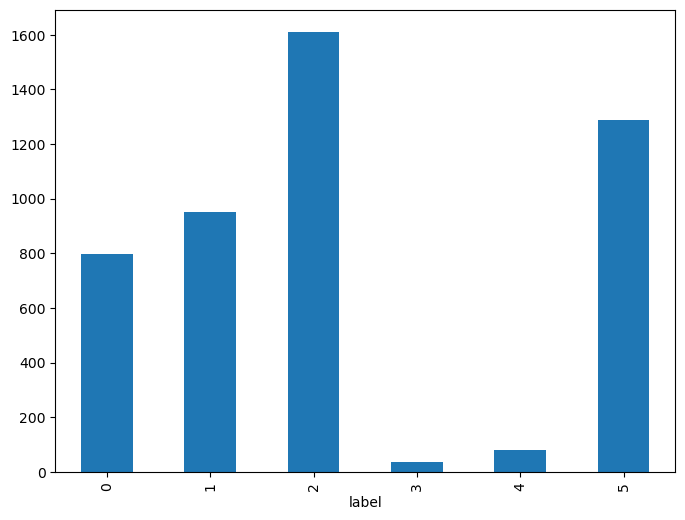

In [11]:
fig = plt.figure(figsize=(8,6))
df.groupby('label').transcription.count().plot.bar(ylim=0)
plt.show()

In [12]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.transcription).toarray()

labels = df.label
print(features.shape)

(4765, 1464)


In [13]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)
# count_vect = CountVectorizer()
# x_train_counts = count_vect.fit_transform(x_train)
# tfidf_transformer = TfidfTransformer()
# x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [14]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

Test Set Accuracy =  0.847
Test Set F-score =  0.793
Test Set Precision =  0.895
Test Set Recall =  0.740
Confusion matrix, without normalization
[[118   3   9   0   0  20]
 [  0 175  10   0   1  15]
 [  6   2 269   0   0  50]
 [  0   0   2   3   0   0]
 [  1   0   1   0   7   7]
 [  0   4  15   0   0 235]]


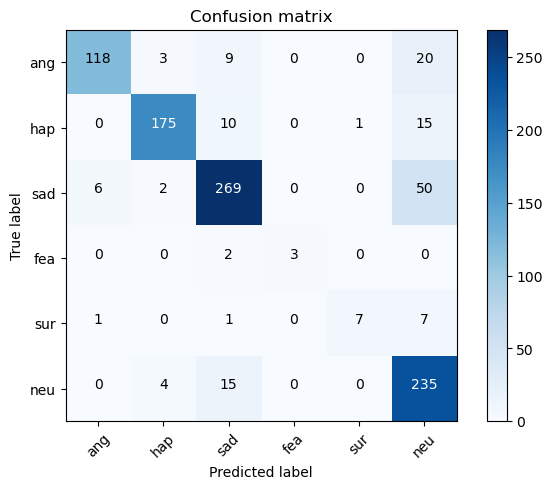

In [15]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\xgboost\core.py:158: UserWarning: [14:44:33] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy =  0.651
Test Set F-score =  0.670
Test Set Precision =  0.833
Test Set Recall =  0.626
Confusion matrix, without normalization
[[ 54   1  84   0   0  11]
 [  0  94  72   0   1  34]
 [  4   0 297   0   0  26]
 [  0   0   0   5   0   0]
 [  1   0   8   0   6   1]
 [  0   0  90   0   0 164]]


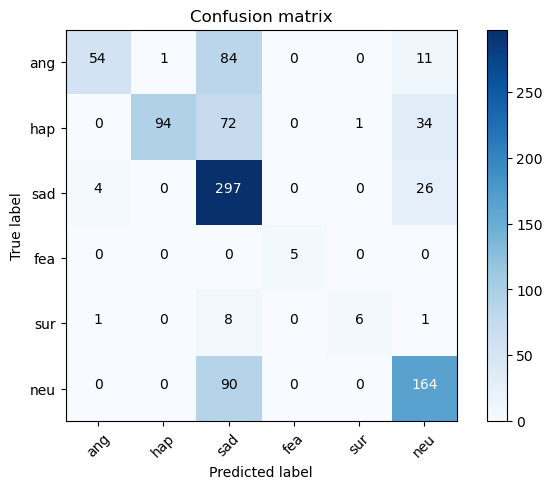

In [16]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=600, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.816
Test Set F-score =  0.772
Test Set Precision =  0.876
Test Set Recall =  0.719
Confusion matrix, without normalization
[[114   2  14   0   0  20]
 [  0 163  15   0   1  22]
 [  9   2 260   0   0  56]
 [  0   0   2   3   0   0]
 [  1   0   1   0   7   7]
 [  4   3  16   0   0 231]]


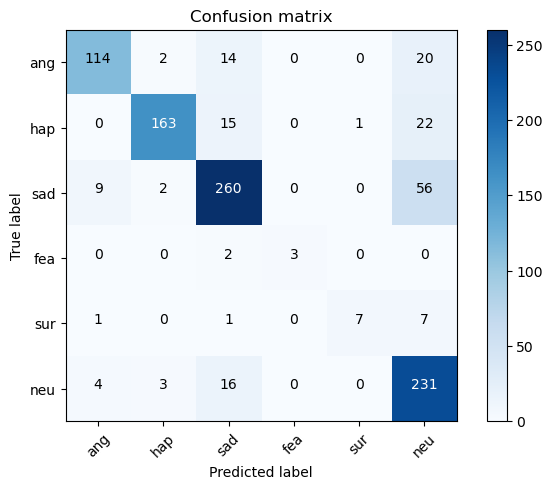

In [17]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emotion_dict.keys())
(y_test, pred_probs)

with open('pred_probas/text_svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.723
Test Set F-score =  0.487
Test Set Precision =  0.525
Test Set Recall =  0.473
Confusion matrix, without normalization
[[ 83   4  46   0   0  17]
 [  0 138  32   0   0  31]
 [  8   4 277   0   0  38]
 [  0   1   4   0   0   0]
 [  1   1   9   0   0   5]
 [  0   1  62   0   0 191]]


c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


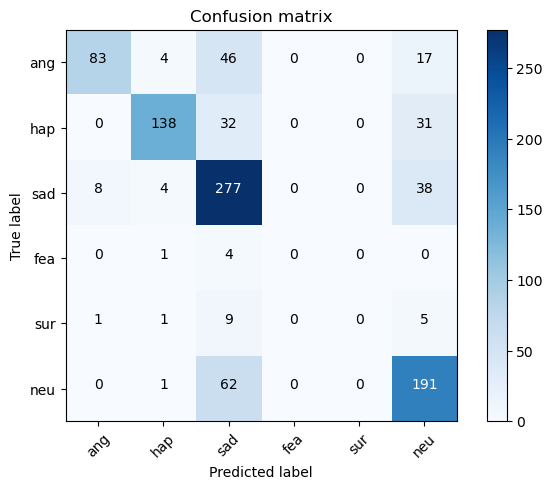

In [18]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.871
Test Set F-score =  0.859
Test Set Precision =  0.909
Test Set Recall =  0.830
Confusion matrix, without normalization
[[122   3  16   0   0   9]
 [  0 181  12   0   1   7]
 [  7   2 295   0   0  23]
 [  0   0   0   5   0   0]
 [  0   0   5   0   8   3]
 [  0   1  34   0   0 219]]


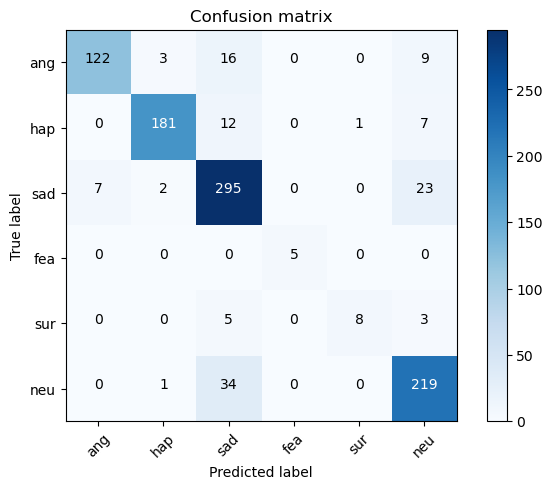

In [19]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Set Accuracy =  0.767
Test Set F-score =  0.613
Test Set Precision =  0.879
Test Set Recall =  0.563
Confusion matrix, without normalization
[[103   2  31   0   0  14]
 [  0 147  28   0   0  26]
 [  7   1 280   0   0  39]
 [  0   1   3   1   0   0]
 [  1   0   7   0   2   6]
 [  1   2  53   0   0 198]]


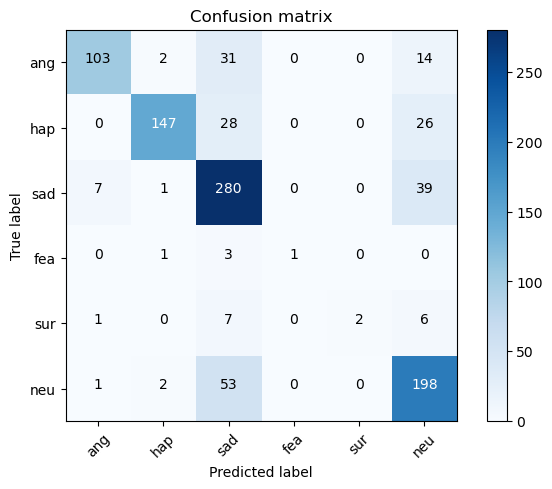

In [20]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

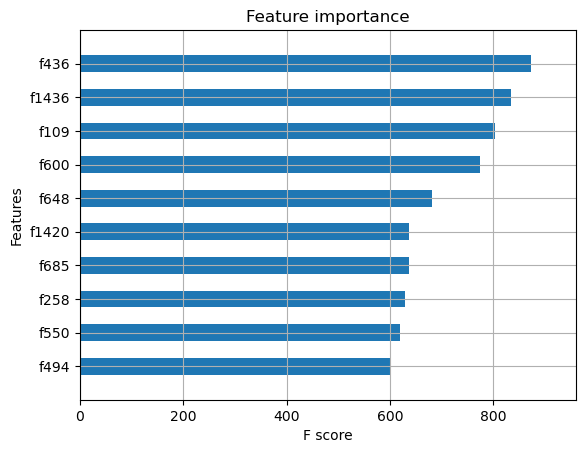

In [21]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)

In [22]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.00057664, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [23]:
with open('pred_probas/text_lstm_classifier.pkl', 'rb') as f:
    lstm_pred_probs = pickle.load(f)
    
display_results(y_test, lstm_pred_probs)

FileNotFoundError: [Errno 2] No such file or directory: 'pred_probas/text_lstm_classifier.pkl'

Test Set Accuracy =  0.857
Test Set F-score =  0.800
Test Set Precision =  0.902
Test Set Recall =  0.744
Confusion matrix, without normalization
[[121   2  17   0   0  10]
 [  0 175  14   0   1  11]
 [  7   1 297   0   0  22]
 [  0   0   2   3   0   0]
 [  1   0   4   0   7   4]
 [  0   0  40   0   0 214]]


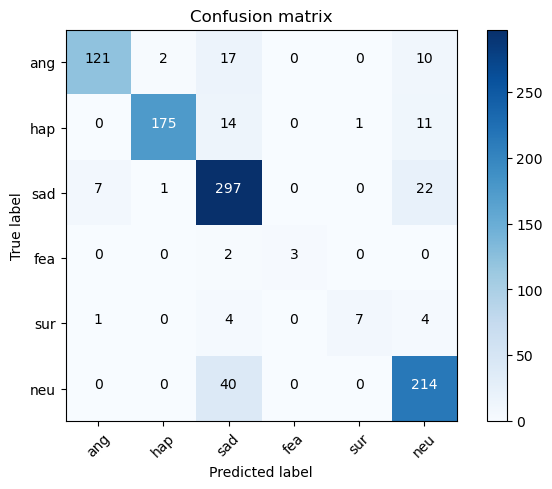

In [24]:
# Load predicted probabilities
with open('pred_probas/text_rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('pred_probas/text_xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/text_svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('pred_probas/text_mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('pred_probas/text_mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('pred_probas/text_lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)


# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/5.0


# Show metrics
display_results(y_test, ensemble_pred_probs)

In [25]:
top_n = [500, 1000, 1500, 2000]  # number of features
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                              n_estimators=600, sub_sample = 0.8, num_class = len(emotion_dict),
                                              booster='gbtree', n_jobs=4)
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)

Stats for top 500 features:


AttributeError: 'super' object has no attribute '__sklearn_tags__'